In [1]:
import warnings
# Disable all warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
import numpy as np
# for building linear regr}ession models and preparing data
from sklearn.linear_model import LinearRegression ,LogisticRegression,RidgeCV,Lasso,Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder,MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import mean_squared_error
from xgboost import *
from sklearn.svm import SVR
from sklearn.metrics import silhouette_score
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV ,cross_val_score,ShuffleSplit
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingRegressor

In [3]:
data = pd.read_csv('/kaggle/input/laptop-price/laptop_price.csv', encoding="ISO-8859-1")

In [4]:
data=data.sample(len(data))

In [5]:
data.isnull().sum()

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

In [6]:
data.isnull().any(axis=1).sum()

0

In [7]:
data.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


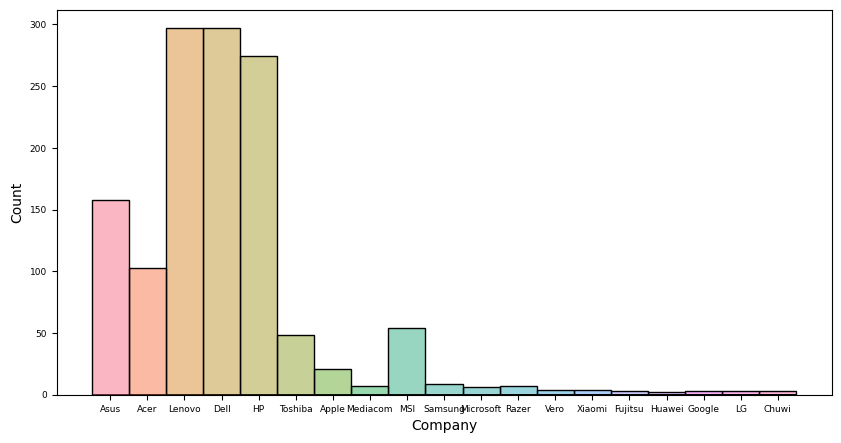

In [8]:
fig,ax=plt.subplots(figsize=(10,5))
sns.histplot(data=data,x='Company', bins=len(data.Company), hue=data.Company,ax=ax,legend=False)
ax.tick_params(labelsize=6.5)

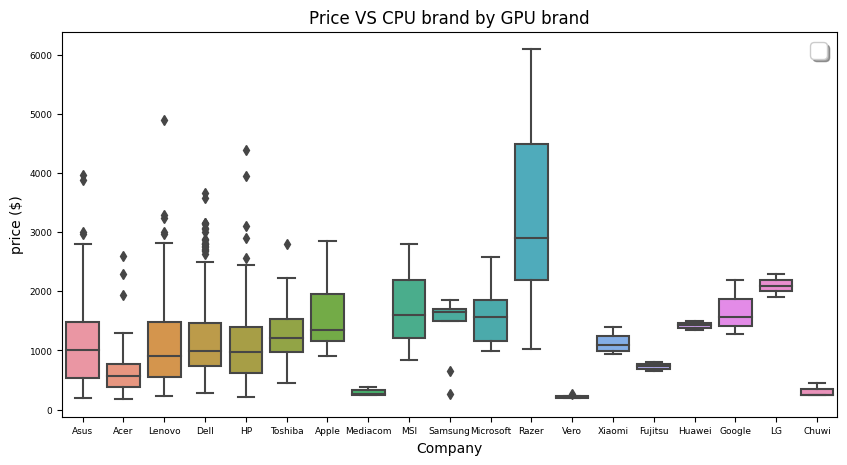

In [9]:
fig,ax=plt.subplots(figsize=(10,5))
ax.tick_params(labelsize=6.5)

sns.boxplot(x='Company', y='Price_euros', data=data)
ax.set_title('Price vs Company')
plt.ylabel('price ($)')
plt.legend(loc='upper right', ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)
plt.title('Price VS CPU brand by GPU brand')
plt.show()

In [10]:
companies = {
    "Apple": 2719000000000,
    "Microsoft": 2200000000000,
    "Google": 1900000000000,
    "Samsung": 346000000000,
    "Huawei": 320000000000,
    "Xiaomi": 190000000000,
    "Dell": 74300000000,
    "Lenovo": 68300000000,
    "Asus": 78200000000,
    "Acer": 14800000000,
    "MSI": 17000000000,
    "Chuwi": 12000000000,
    "Razer": 16000000000,
    "Mediacom": 18400000000,
    "Fujitsu": 46500000000,
    "LG": 17600000000,
    "Vero": 10000000000
    ,
     'Toshiba':14000000900
    ,
    "HP":35500000000
}
data['Company']=data['Company'].apply(lambda x:companies[x] )

In [11]:
"""data['Ram']=data['Ram'].apply(lambda x: float(x[:-2]))
data['Weight']=data['Weight'].apply(lambda x: float(x[:-2]))
data['Memory']=data['Memory'].apply(lambda x: 'SSD' in x)"""

"data['Ram']=data['Ram'].apply(lambda x: float(x[:-2]))\ndata['Weight']=data['Weight'].apply(lambda x: float(x[:-2]))\ndata['Memory']=data['Memory'].apply(lambda x: 'SSD' in x)"

<AxesSubplot: xlabel='Price_euros'>

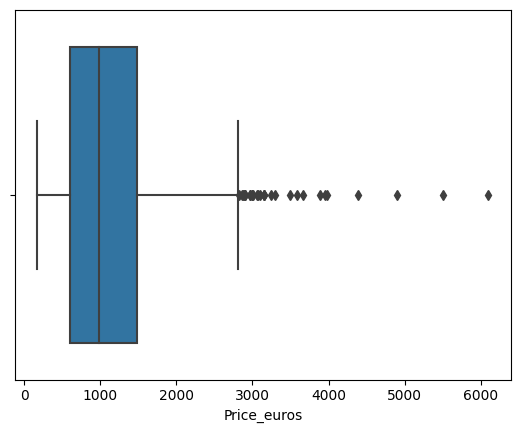

In [12]:
sns.boxplot(data=data,x='Price_euros')

In [13]:
var=data['Price_euros'].std()
mean=data['Price_euros'].mean()
data['Price_euros']=np.where(data['Price_euros']>mean+var*2.5, mean+var*2.5,np.where(data['Price_euros']<mean-var*4,mean-var*4,data['Price_euros']))

<AxesSubplot: xlabel='Price_euros'>

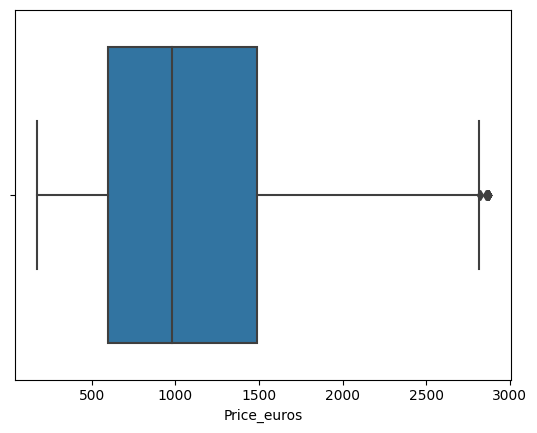

In [14]:
sns.boxplot(data=data,x='Price_euros')

In [15]:
df = data.drop(['laptop_ID'],axis=1)
# Drop rows that have missing values
df = df.dropna()
df['SSD'] = np.zeros(len(df))
df['HDD'] = np.zeros(len(df))
df['FlashStorage'] = np.zeros(len(df))
df['Hybrid'] = np.zeros(len(df))
for i in range(len(df['Memory'])):
    arr = df['Memory'][i].split("+")
    arr = [x.replace(" ","") for x in arr]
    for x in arr:
        if 'TB' in x:
            
            x = x.split("TB")
            num = float(x[0])*1000
            df[x[1]][i] = num
            
        elif 'GB' in x:
            x = x.split("GB")
            num = float(x[0])
            df[x[1]][i] = num
            
        
            
df['Memory'] = df['SSD'] + df['HDD'] + df['FlashStorage'] + df['Hybrid']
df['Ram'] = df['Ram'].str.replace('GB','')
df['Weight'] = df['Weight'].apply(lambda x: float(x.strip("kg")))
for i in range(len(df['OpSys'])):
    if 'Windows' in df['OpSys'][i]:
        df['OpSys'][i] = 'Windows'
    elif 'mac' in df['OpSys'][i].lower():
        df['OpSys'][i] = 'Mac'
    else:
        df['OpSys'][i] = 'Other'

df['ScreenResolution'] = df['ScreenResolution'].apply(lambda x: x.split(" ")[-1])

df['CpuHz'] = df['Cpu'].apply(lambda x: x.split(" ")[-1])
df['CpuHz'] = df['CpuHz'].str.replace('GHz','')
df['CpuMaker'] = df['Cpu'].apply(lambda x: x.split(" ")[0])
df['CpuModel'] = df['Cpu'].apply(lambda x: x.split(" ")[1])
for i in range(len(df['CpuMaker'])):
    if df['CpuMaker'][i] == 'Intel':
        df['CpuModel'][i] = " ".join(df['Cpu'][i].split(" ")[0:-1]).replace(" ","")
    else:
        df['CpuModel'][i] = "AMD"

df = df.drop('Cpu',axis=1)
data = df.drop('CpuMaker',axis=1)

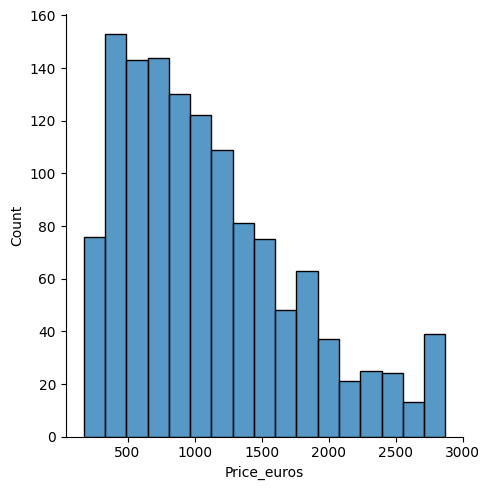

In [16]:
sns.displot(data['Price_euros'])

In [17]:
y=np.log(data['Price_euros'])
data.drop(columns=['Price_euros'],inplace=True)

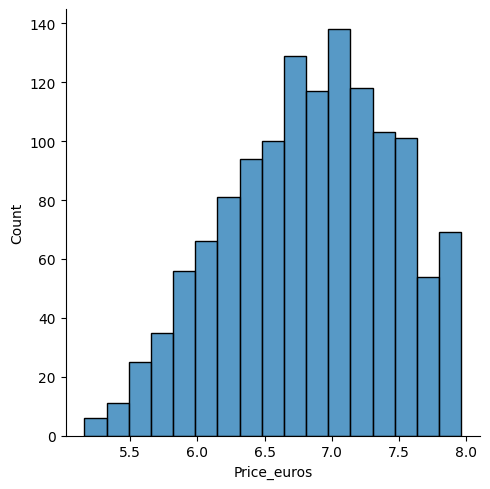

In [18]:
sns.displot(y)

In [19]:
title=['Company',  'Weight','Ram','Inches','Memory','Product', 'TypeName',  'ScreenResolution', 
        'Gpu', 'OpSys', 'SSD', 'HDD', 'FlashStorage',
       'Hybrid', 'CpuHz', 'CpuModel']

array([[<AxesSubplot: title={'center': 'Company'}>,
        <AxesSubplot: title={'center': 'Inches'}>,
        <AxesSubplot: title={'center': 'Memory'}>],
       [<AxesSubplot: title={'center': 'Weight'}>,
        <AxesSubplot: title={'center': 'SSD'}>,
        <AxesSubplot: title={'center': 'HDD'}>],
       [<AxesSubplot: title={'center': 'FlashStorage'}>,
        <AxesSubplot: title={'center': 'Hybrid'}>, <AxesSubplot: >]],
      dtype=object)

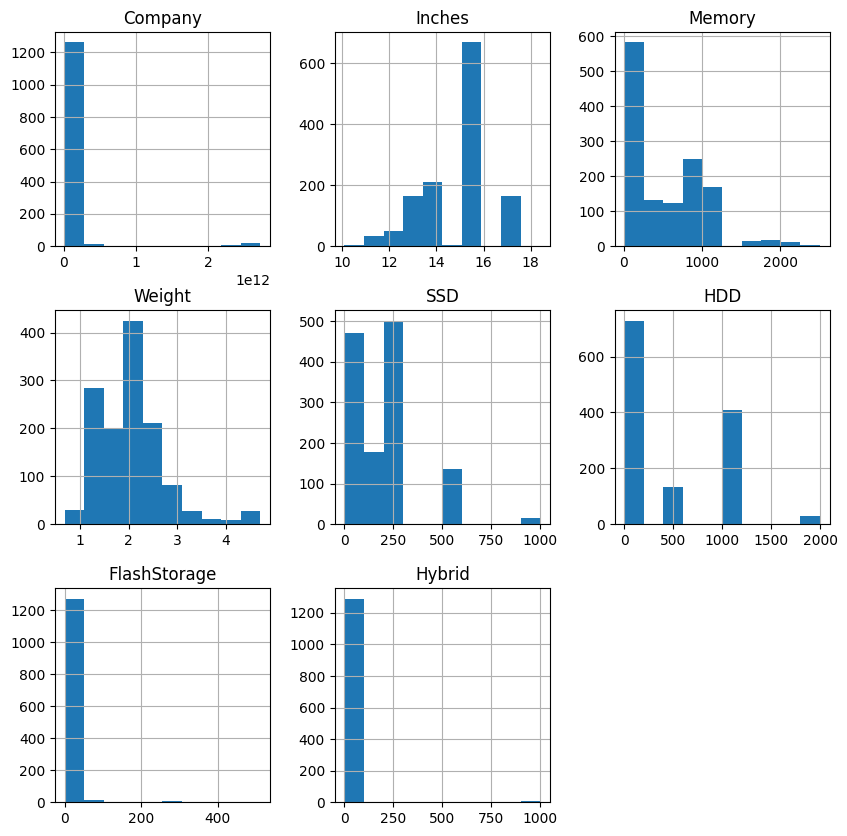

In [20]:
data.hist(figsize=(10,10))

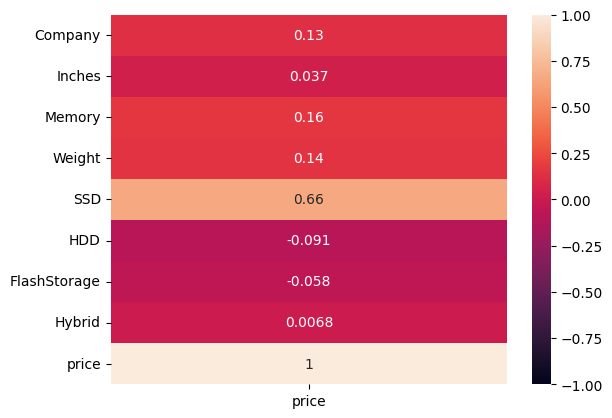

In [21]:
data['price']=y
data.corr()['price']
sns.heatmap(pd.DataFrame( data.corr()['price']),  annot=True, vmin=-1, vmax=1)
data.drop(columns=['price'],inplace=True)

In [22]:
data=data.reindex(columns=title)

In [23]:
encoder=LabelEncoder()
for cols in  data.iloc[:,5:]:
  data[cols]=encoder.fit_transform(data[cols])

In [24]:
data

,Company,Weight,Ram,Inches,Memory,Product,TypeName,ScreenResolution,Gpu,OpSys,SSD,HDD,FlashStorage,Hybrid,CpuHz,CpuModel
378,78200000000,1.50,4,14.0,32.0,535,3,0,43,2,0,0,2,0,2,10
254,14800000000,3.00,4,17.3,256.0,59,3,3,97,2,8,0,0,0,21,27
691,68300000000,1.70,4,14.0,256.0,221,3,3,53,2,8,0,0,0,18,34
442,68300000000,1.36,8,12.5,256.0,473,4,3,53,2,8,0,0,0,18,34
689,68300000000,2.10,4,15.6,500.0,506,3,0,45,2,0,3,0,0,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,74300000000,2.20,2,15.6,500.0,238,3,0,40,2,0,3,0,0,7,8
1167,68300000000,2.20,4,15.6,1000.0,52,3,3,67,2,0,4,0,0,12,24
456,74300000000,4.42,8,17.3,1000.0,56,3,3,79,2,0,4,0,0,21,54
1155,35500000000,1.91,4,15.6,256.0,30,3,3,6,2,8,0,0,0,18,0


In [25]:
x_train,x_test,y_train,y_test=train_test_split(data,y,test_size=.1)

In [26]:
result=pd.DataFrame(columns=["cross validtion score","test score"])

In [27]:
# Create the Ridge regression model
ridge = Pipeline([("poly",PolynomialFeatures(degree=3)),("maxmin",MinMaxScaler()),("ridge",Ridge())])


# Define the parameter grid
param_grid = {
    'ridge__alpha': [.0001,.001,.01,0.1, 1.0, 10.0],
    'ridge__fit_intercept': [True, False],
    'ridge__solver': ['auto', 'svd', 'cholesky']
}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5)
grid_search1.fit(x_train, y_train)
print("Best Parameters:", grid_search1.best_params_)
print("Best Score:", grid_search1.best_score_)

Best Parameters: {'ridge__alpha': 1.0, 'ridge__fit_intercept': True, 'ridge__solver': 'auto'}
Best Score: 0.8365900641156289


In [28]:
param_grid=param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [6, 12,16],
    'n_estimators': [100, 200, 300, 1000]
}
grid_search2 = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5)
grid_search2.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [80, 90, 100, 110],
                         'max_features': [6, 12, 16],
                         'n_estimators': [100, 200, 300, 1000]})

In [29]:
print("Best Parameters:", grid_search2.best_params_)
print("Best Score:", grid_search2.best_score_)

Best Parameters: {'max_depth': 110, 'max_features': 6, 'n_estimators': 300}
Best Score: 0.9157486385546549


In [30]:
param_grid = {
 "knn__n_neighbors":[10,5,100,50,30,80,20]
}

grid_search4 = GridSearchCV(estimator= Pipeline([("poly",PolynomialFeatures(degree=2)),("maxmin",MinMaxScaler()),("knn",KNeighborsRegressor())]), param_grid=param_grid, cv=5)
grid_search4.fit(x_train, y_train)

print("Best Parameters:", grid_search4.best_params_)
print("Best Score:", grid_search4.best_score_)

Best Parameters: {'knn__n_neighbors': 5}
Best Score: 0.8227182128796512


In [31]:
param_grid = {
    'svr__kernel': ['linear','poly', 'rbf'],
    'svr__C': [0.1, 1.0, .01,.001],
    'svr__degree': [2, 3,4]
}

grid_search3 = GridSearchCV(estimator=Pipeline([("maxmin",StandardScaler()),("svr",SVR())]), param_grid=param_grid, cv=5)
grid_search3.fit(x_train, y_train)

print("Best Parameters:", grid_search3.best_params_)
print("Best Score:", grid_search3.best_score_)

Best Parameters: {'svr__C': 1.0, 'svr__degree': 2, 'svr__kernel': 'rbf'}
Best Score: 0.8763760932477661


In [32]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}
grid_search5 = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, cv=5)
grid_search5.fit(x_train, y_train)
print("Best Parameters:", grid_search5.best_params_)
print("Best Score:", grid_search5.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Best Score: 0.9243869937315219


In [33]:
n=cross_val_score(grid_search3.best_estimator_,x_train,y_train).mean()
Extra_tree=grid_search3.best_estimator_
Extra_tree.fit(x_train,y_train)
w=Extra_tree.score(x_test,y_test)
result.loc["SVR"]=[n,w]

In [34]:

n=cross_val_score(grid_search2.best_estimator_,x_train,y_train).mean()
Extra_tree=grid_search2.best_estimator_
Extra_tree.fit(x_train,y_train)
w=Extra_tree.score(x_test,y_test)
result.loc["Random Forest Regressor",]=[n,w]

In [35]:
ridge=grid_search1.best_estimator_
n=cross_val_score(ridge,x_train,y_train).mean()
Extra_tree=ridge
Extra_tree.fit(x_train,y_train)
w=Extra_tree.score(x_test,y_test)
result.loc["Ridge"]=[n,w]

In [36]:
ridge=grid_search5.best_estimator_
n=cross_val_score(ridge,x_train,y_train).mean()
Extra_tree=ridge
Extra_tree.fit(x_train,y_train)
w=Extra_tree.score(x_test,y_test)
result.loc["Gradient Boosting Regressor"]=[n,w]

In [37]:
ridge=grid_search4.best_estimator_
n=cross_val_score(ridge,x_train,y_train).mean()
Extra_tree=ridge
Extra_tree.fit(x_train,y_train)
w=Extra_tree.score(x_test,y_test)
result.loc["KNN"]=[n,w]

In [38]:
result

,cross validtion score,test score
SVR,0.876376,0.890756
Random Forest Regressor,0.915755,0.932868
Ridge,0.836590,0.864475
Gradient Boosting Regressor,0.924842,0.937040
KNN,0.822718,0.851965
